In [39]:
#from kjkutils import *
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


In [32]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

In [4]:
sGraphite = Shower("/Users/kjkelly/Documents/GitHub/PETITE/RyanDicts/Mar24_", "graphite", 0.010)
sLead = Shower("/Users/kjkelly/Documents/GitHub/PETITE/RyanDicts/Mar24_", "lead", 0.010)

In [6]:
EVec = np.logspace(np.log10(0.0015), np.log10(100.), 100)

In [7]:
EVec[58], EVec[73]

(1.0051239289306901, 5.4089737788907355)

Do some toy accept/reject for bremsstrahlung with E_{e} = 1 GeV, sampling from several integrators trained at nearby energies

In [9]:
xs0 = []
trials0 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 59, 'Brem', VB=True)
    xs0.append(s0[0])
    trials0.append(s0[-1])

xs1 = []
trials1 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 60, 'Brem', VB=True)
    xs1.append(s0[0])
    trials1.append(s0[-1])

xs2 = []
trials2 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 61, 'Brem', VB=True)
    xs2.append(s0[0])
    trials2.append(s0[-1])

xs3 = []
trials3 = []
for k in range(int(1e5)):
    s0 = sGraphite.draw_sample(1.00512, 62, 'Brem', VB=True)
    xs3.append(s0[0])
    trials3.append(s0[-1])

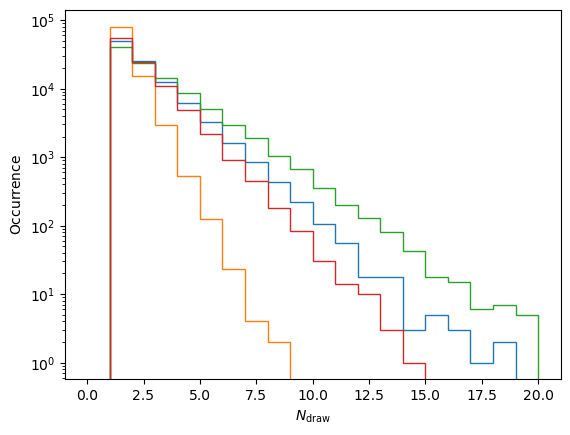

In [14]:
plt.hist(trials0, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.hist(trials1, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.hist(trials2, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.hist(trials3, bins=np.linspace(0, 20, 21), histtype='step', lw=1)
plt.gca().set_xlabel(r"$N_{\rm draw}$")
plt.gca().set_ylabel(r"$\mathrm{Occurrence}$")
plt.gca().set_yscale('log')

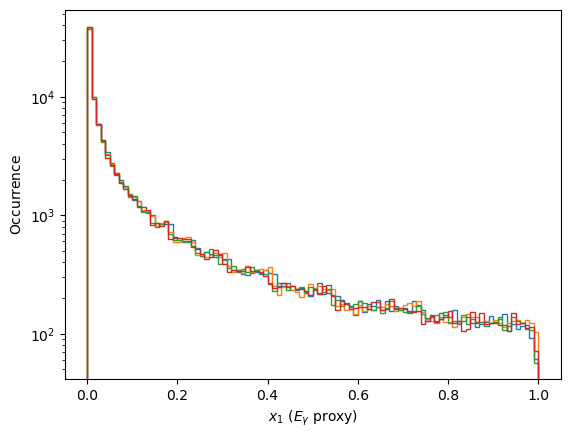

In [15]:
plt.hist(xs0, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs1, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs2, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs3, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.gca().set_xlabel(r"$x_1\ (E_{\gamma}\ \rm{proxy})$")
plt.gca().set_ylabel(r"$\mathrm{Occurrence}$")
plt.gca().set_yscale('log')

Compare cross sections with new, rotated phase space with older ones

In [17]:
dicts_old = pk.load(open("/Users/kjkelly/Documents/Github/PETITE/RyanDicts/Feb13_xSec_Dicts.pkl", "rb"))
dicts_new = pk.load(open("/Users/kjkelly/Documents/Github/PETITE/RyanDicts/Mar24_xSec_Dicts.pkl", "rb"))
dicts_new_neval = pk.load(open("/Users/kjkelly/Documents/Github/PETITE/RyanDicts/Mar24_xSec_Dicts_neval.pkl", "rb"))

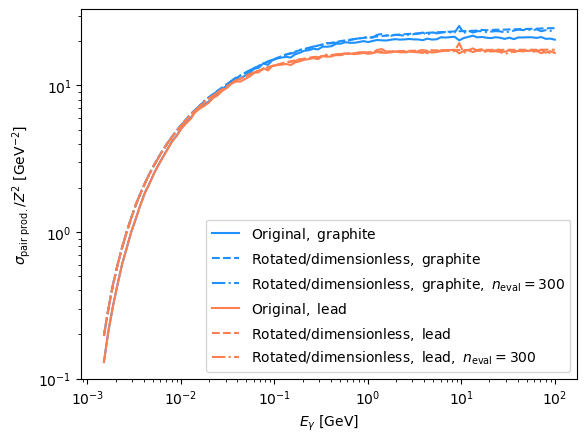

In [18]:
plt.plot(np.transpose(dicts_old['PairProd']['graphite'])[0], np.transpose(dicts_old['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='-', label=r"$\mathrm{Original,\ graphite}$")
plt.plot(np.transpose(dicts_new['PairProd']['graphite'])[0], np.transpose(dicts_new['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ graphite}$")
plt.plot(np.transpose(dicts_new_neval['PairProd']['graphite'])[0], np.transpose(dicts_new_neval['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ graphite,\ }n_{\rm eval}=300$")
plt.plot(np.transpose(dicts_old['PairProd']['lead'])[0], np.transpose(dicts_old['PairProd']['lead'])[1]/82**2, color='coral', ls='-', label=r"$\mathrm{Original,\ lead}$")
plt.plot(np.transpose(dicts_new['PairProd']['lead'])[0], np.transpose(dicts_new['PairProd']['lead'])[1]/82**2, color='coral', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ lead}$")
plt.plot(np.transpose(dicts_new_neval['PairProd']['lead'])[0], np.transpose(dicts_new_neval['PairProd']['lead'])[1]/82**2, color='coral', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ lead,\ }n_{\rm eval}=300$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{\gamma}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma_{\rm pair\ prod.}/Z^2\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


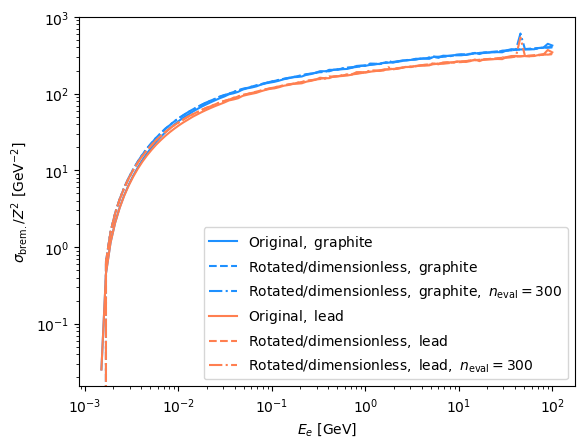

In [19]:
plt.plot(np.transpose(dicts_old['Brem']['graphite'])[0], np.transpose(dicts_old['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='-', label=r"$\mathrm{Original,\ graphite}$")
plt.plot(np.transpose(dicts_new['Brem']['graphite'])[0], np.transpose(dicts_new['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ graphite}$")
plt.plot(np.transpose(dicts_new_neval['Brem']['graphite'])[0], np.transpose(dicts_new_neval['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ graphite,\ }n_{\rm eval}=300$")
plt.plot(np.transpose(dicts_old['Brem']['lead'])[0], np.transpose(dicts_old['Brem']['lead'])[1]/82**2, color='coral', ls='-', label=r"$\mathrm{Original,\ lead}$")
plt.plot(np.transpose(dicts_new['Brem']['lead'])[0], np.transpose(dicts_new['Brem']['lead'])[1]/82**2, color='coral', ls='--', label=r"$\mathrm{Rotated/dimensionless,\ lead}$")
plt.plot(np.transpose(dicts_new_neval['Brem']['lead'])[0], np.transpose(dicts_new_neval['Brem']['lead'])[1]/82**2, color='coral', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ lead,\ }n_{\rm eval}=300$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma_{\rm brem.}/Z^2\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


Make some showers!

In [20]:
E0 = 10.
p0 = Particle(11, E0, 0., 0., np.sqrt(E0**2 - 0.000511**2), 0, 0, 0, 1, 0, 0, 0, -1, 1.)
p0G = Particle(22, E0, 0, 0, E0, 0, 0, 0, 1, 0, 0, 0, -1, 1.)

Check shower timing

In [21]:
def slowShower():
    s0 = sGraphite.generate_shower(11, p0.get_p0(), 22, VB=True)
    return

In [24]:
profileSS = cProfile.Profile()
profileSS.runcall(slowShower)
psSS = pstats.Stats(profileSS)
psSS.print_stats()

Starting shower, initial particle with ID Info
[11.  1. 22.  0.  0. -1.  1.]
Initial four-momenta:
[10.          0.          0.          9.99999999]
         1107259 function calls (1101899 primitive calls) in 0.445 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10832    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
      791    0.000    0.000    0.000    0.000 {method 'bit_length' of 'int' objects}
     4506    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'update' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
        2    0.000    0.000    0.000    0.000 {method 'discard' of 'set' objects}
       11    0.000    0.000    0.000    0.000 {method 'split' of 'str' objects}
        2    0.000 

In [25]:
SMS = sGraphite.generate_shower(11, p0.get_p0(), 22, VB=True)
SMSLead = sLead.generate_shower(11, p0.get_p0(), 22, VB=True)

Starting shower, initial particle with ID Info
[11.  1. 22.  0.  0. -1.  1.]
Initial four-momenta:
[10.          0.          0.          9.99999999]
Starting shower, initial particle with ID Info
[11.  1. 22.  0.  0. -1.  1.]
Initial four-momenta:
[10.          0.          0.          9.99999999]


In [30]:
SMSPhotons = np.array(SMS)[np.where([ps.get_ids()[0] == 22 for ps in SMS])[0]]
SMSPhotonsLead = np.array(SMSLead)[np.where([ps.get_ids()[0] == 22 for ps in SMSLead])[0]]
SMSElectrons = np.array(SMS)[np.where([ps.get_ids()[0] == 11 for ps in SMS])[0]]
SMSPositrons = np.array(SMS)[np.where([ps.get_ids()[0] == -11 for ps in SMS])[0]]

In [31]:
PhotonEs = np.array([s.get_p0()[0] for s in SMSPhotons])
PhotonEsLead = np.array([s.get_p0()[0] for s in SMSPhotonsLead])

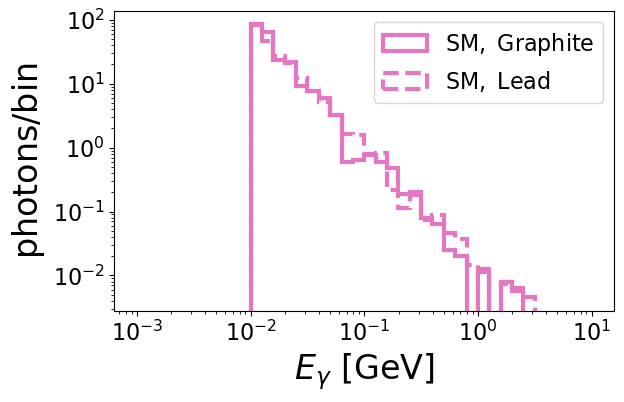

In [37]:
b0 = np.logspace(-3, 1, 41)

plt.hist(PhotonEs, bins=b0, histtype='step', lw=3, color='C6', density=True, ls='-', label=r"$\mathrm{SM,\ Graphite}$")
plt.hist(PhotonEsLead, bins=b0, histtype='step', lw=3, color='C6', density=True, ls='--', label=r"$\mathrm{SM,\ Lead}$")

plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


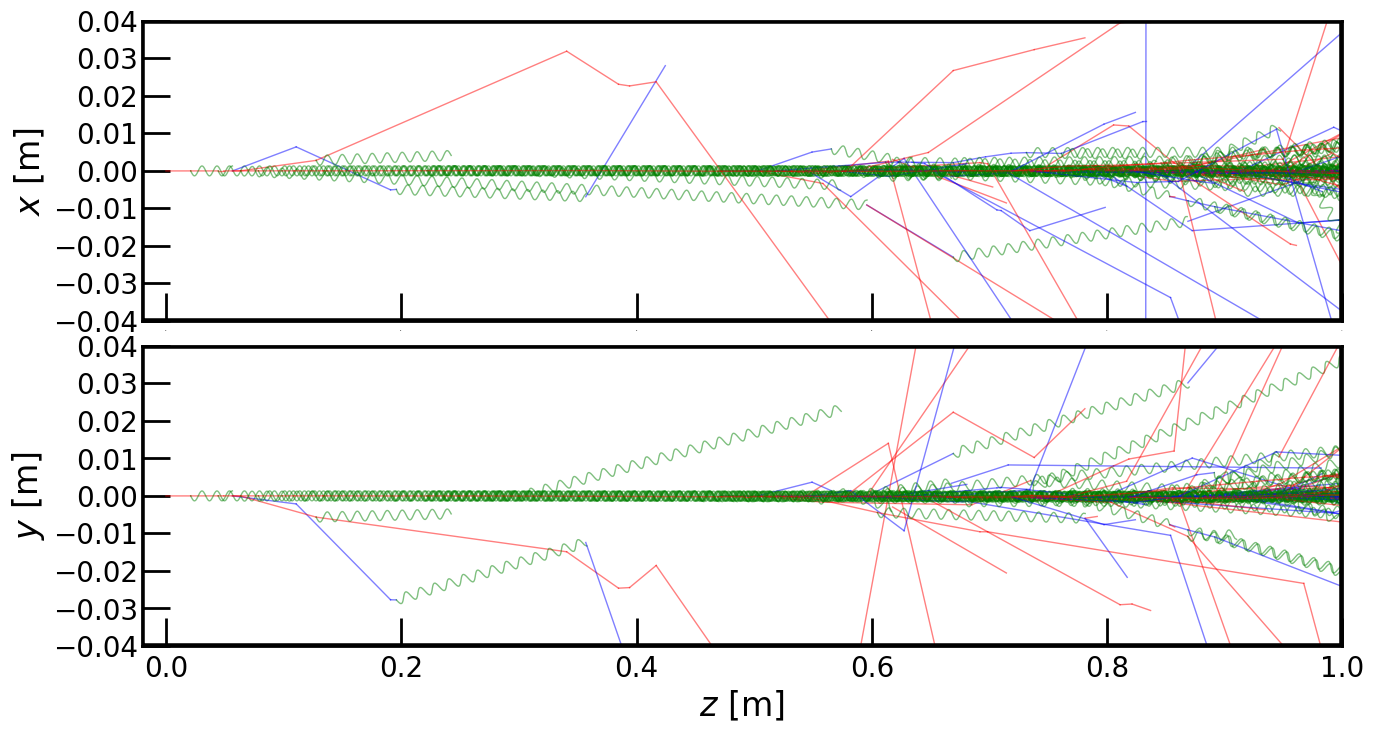

In [40]:
figwid = 6.0*2.0
fighei = 6.0*0.5
lside = 3.0
rside = 3.5
wwspace = 1.25

ncol = 1
nrow = 2

wid = lside + ncol*figwid + (ncol-1)*wwspace + rside

bot = 3.77
top = 3.5
hhspace = 0.25

hei = bot + nrow*fighei + (nrow-1)*hhspace + top

lfactor = lside/wid
rfactor = rside/wid
bfactor = bot/hei
tfactor = top/hei
wfactor = wwspace/figwid
hfactor = hhspace/fighei

matplotlib.rcParams['axes.linewidth'] = 2.0
fig, axes = plt.subplots(nrow, ncol, figsize=(wid, hei), facecolor='1.0');
fig.subplots_adjust(left = lfactor, bottom=bfactor, right=(1.0-rfactor), top=(1.0-tfactor), wspace=wfactor, hspace=hfactor);

xmin, xmax, ymin, ymax = -0.02, 1, -0.04, 0.04
#xmin, xmax, ymin, ymax = -1.0, 5.0, -0.4, 0.4

ax = axes[0]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
#ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$x\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((0)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='g', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='r', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='b', alpha=0.5)

ax = axes[1]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$y\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='g', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='r', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='b', alpha=0.5)



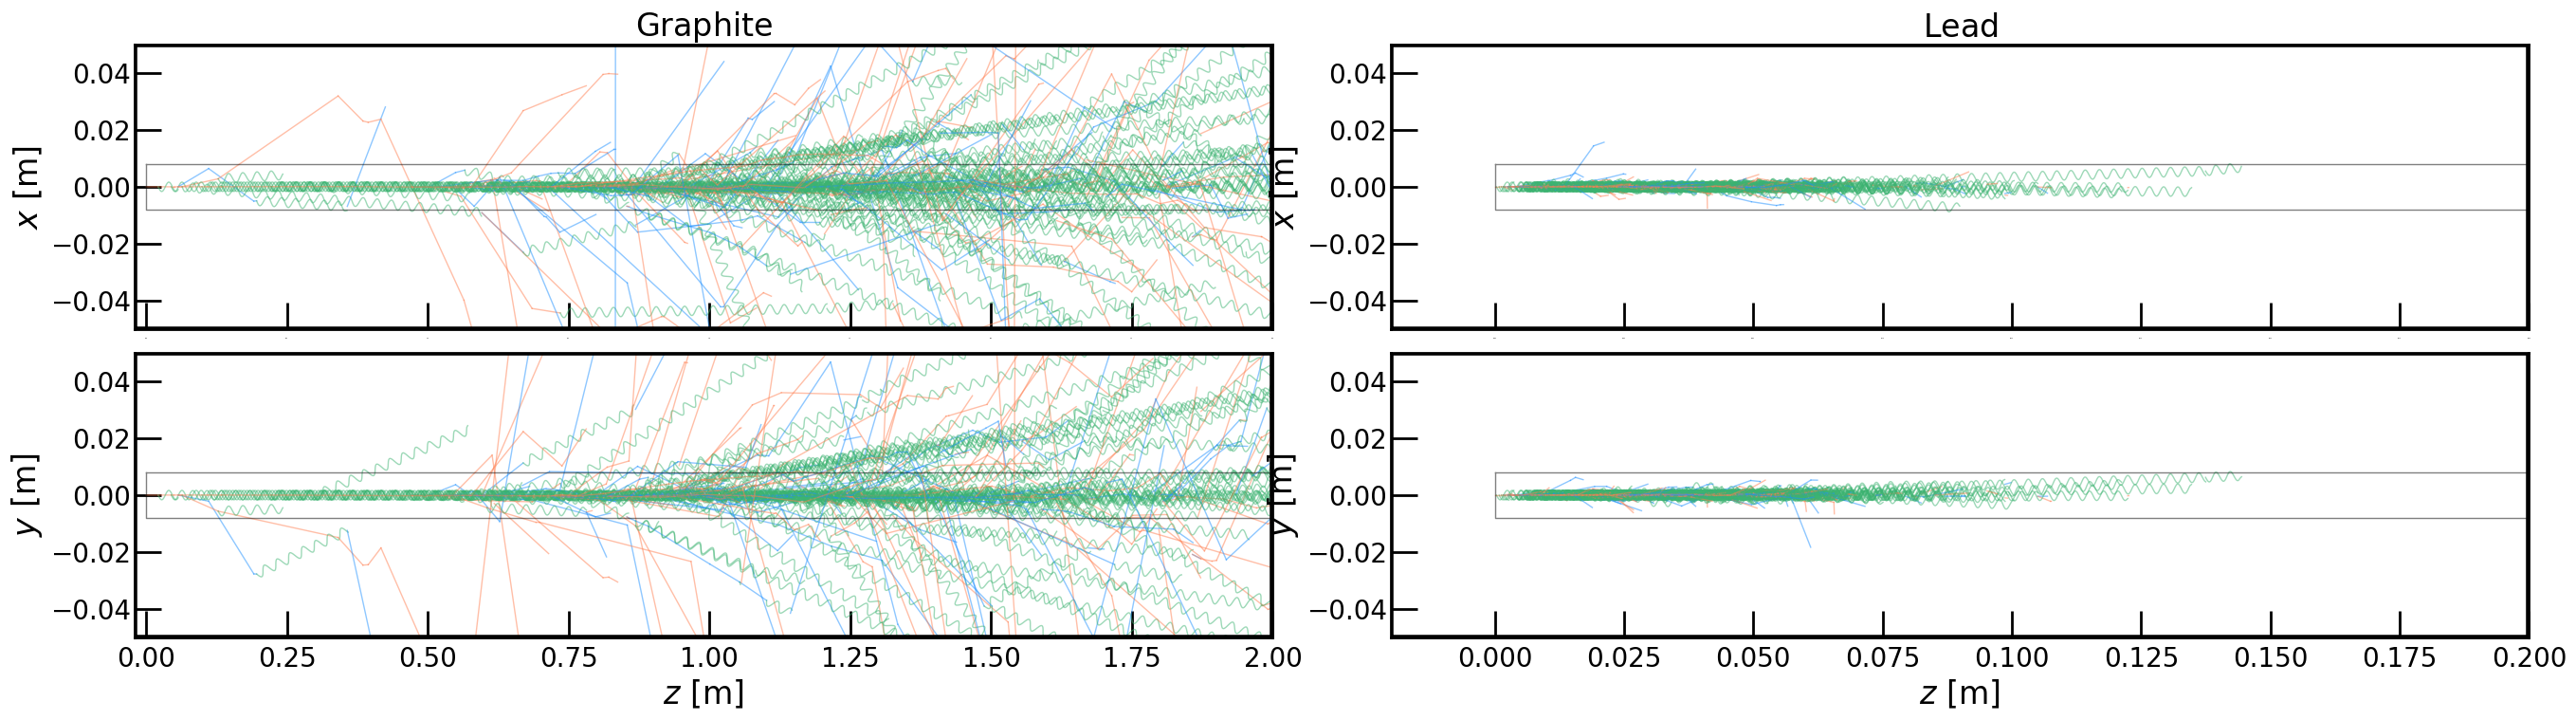

In [41]:
figwid = 6.0*2.0
fighei = 6.0*0.5
lside = 3.0
rside = 3.5
wwspace = 1.25

ncol = 2
nrow = 2

wid = lside + ncol*figwid + (ncol-1)*wwspace + rside

bot = 3.77
top = 3.5
hhspace = 0.25

hei = bot + nrow*fighei + (nrow-1)*hhspace + top

lfactor = lside/wid
rfactor = rside/wid
bfactor = bot/hei
tfactor = top/hei
wfactor = wwspace/figwid
hfactor = hhspace/fighei

matplotlib.rcParams['axes.linewidth'] = 2.0
fig, axes = plt.subplots(nrow, ncol, figsize=(wid, hei), facecolor='1.0');
fig.subplots_adjust(left = lfactor, bottom=bfactor, right=(1.0-rfactor), top=(1.0-tfactor), wspace=wfactor, hspace=hfactor);

xmin, xmax, ymin, ymax = -0.02, 2, -0.05, 0.05
#xmin, xmax, ymin, ymax = -1.0, 5.0, -0.4, 0.4

ax = axes[0][0]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
#ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$x\ [\mathrm{m}]$', fontproperties=font)        
ax.set_title(r"$\mathrm{Graphite}$", fontproperties=font)

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((0)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='dodgerblue', alpha=0.5)

ax = axes[1][0]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$y\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMS:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='dodgerblue', alpha=0.5)


xmin, xmax, ymin, ymax = -0.02, 0.2, -0.05, 0.05


ax = axes[0][1]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
#ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$x\ [\mathrm{m}]$', fontproperties=font)        
ax.set_title(r"$\mathrm{Lead}$", fontproperties=font)

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((0)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMSLead:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[0], ki[3]], lw=1, ls='-', color='dodgerblue', alpha=0.5)

ax = axes[1][1]
ax.axis([xmin, xmax, ymin, ymax])
ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], ls='-', color='k', lw=4, zorder=50)
ax.set_xlabel(r'$z\ [\mathrm{m}]$', fontproperties=font)        
ax.set_ylabel(r'$y\ [\mathrm{m}]$', fontproperties=font)        

ax.tick_params(direction='in', zorder=30, length=20, width=2)
ax.tick_params(direction='in', which='minor', zorder=30, length=15, width=1.5)
[l.set_position((0.5, -0.015)) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_xticklabels()]
[l.set_size((labelfont.get_size())) for l in ax.get_yticklabels()]

for ki0 in SMSLead:
    ki = np.concatenate([ki0.get_r0(), ki0.get_rf()])
    if ki0.get_ids()[0] == 22:
        with matplotlib.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='mediumseagreen', alpha=0.5)
    if ki0.get_ids()[0] == 11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='coral', alpha=0.5)
    if ki0.get_ids()[0] == -11:
        ax.plot([ki[2], ki[5]], [ki[1], ki[4]], lw=1, ls='-', color='dodgerblue', alpha=0.5)

for ax in axes[0]:
    ax.plot([0, 2.2, 2.2, 0, 0], [0.008, 0.008, -0.008, -0.008, 0.008], lw=1, color='k', ls='-', alpha=0.5)
for ax in axes[1]:
    ax.plot([0, 2.2, 2.2, 0, 0], [0.008, 0.008, -0.008, -0.008, 0.008], lw=1, color='k', ls='-', alpha=0.5)


Question to address -- why isn't the lead shower as "messy" as the graphite one?

Generate some ensembles of brem./pair production samples, with 10 GeV particles injected

In [42]:
nSamp = 200000
s0 = np.array([sGraphite.electron_brem_sample(p0, VB=True) for i in range(nSamp)])
s0G = np.array([sGraphite.pairprod_sample(p0G, VB=True) for i in range(nSamp)])

In [43]:
Es = np.array([s[1].get_p0()[0] for s in s0])
EsE = np.array([s[0].get_p0()[0] for s in s0])

EsG = np.array([s[1].get_p0()[0] for s in s0G])
EsGP = np.array([s[0].get_p0()[0] for s in s0G])

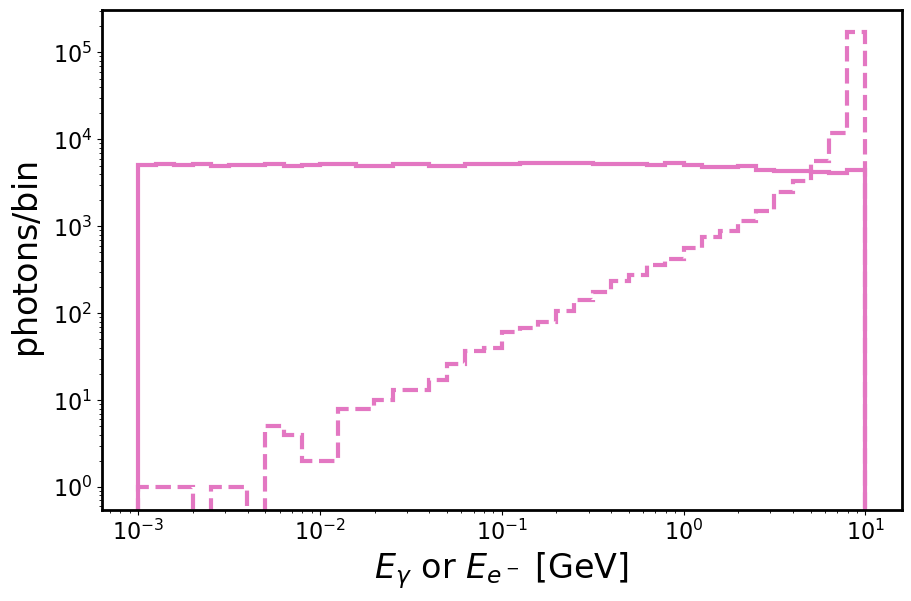

In [44]:
b0 = np.logspace(-3, 1, 41)

dens = False
plt.hist(Es, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")
plt.hist(EsE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

#plt.gca().legend(loc='best', fontsize=16, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ \mathrm{or}\ E_{e^-}\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


In [45]:
pTpz = np.array([(s[1].get_p0()[3]/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0])
pTpzE = np.array([(s[0].get_p0()[3]/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0])

pTpzG = np.array([(s[1].get_p0()[3]/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0G])
pTpzGP = np.array([(s[0].get_p0()[3]/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0G])

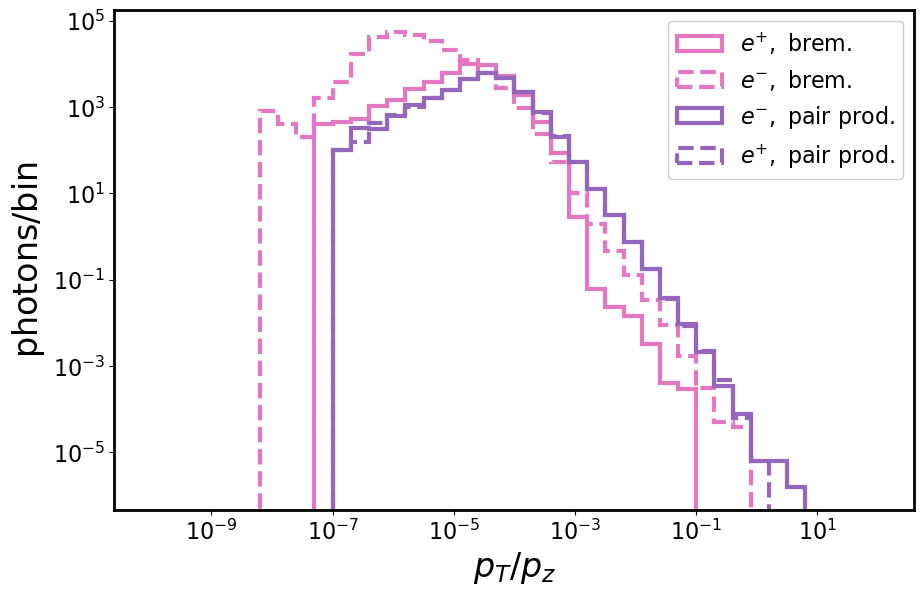

In [49]:
b0 = np.logspace(-10, 2, 41)

dens = True
plt.hist(pTpz, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$e^{+},\ \rm{brem.}$")
plt.hist(pTpzE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--', label=r"$e^{-},\ \rm{brem.}$")

plt.hist(pTpzG, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='-', label=r"$e^{-},\ \rm{pair\ prod.}$")
plt.hist(pTpzGP, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='--', label=r"$e^{+},\ \rm{pair\ prod.}$")

plt.gca().legend(loc='best', fontsize=16, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$p_T/p_z$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


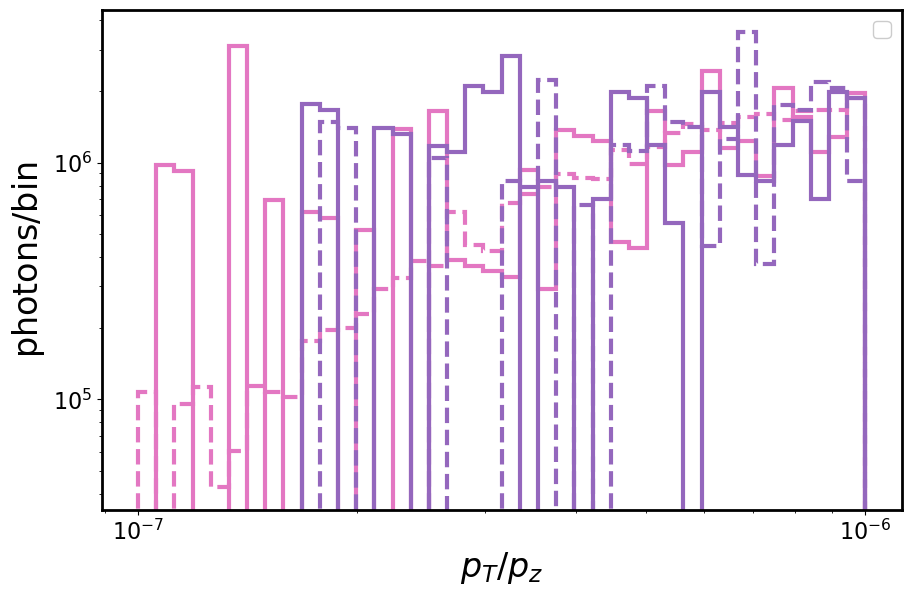

In [50]:
b0 = np.logspace(-7, -6, 41)

dens = True
plt.hist(pTpz, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-')
plt.hist(pTpzE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

plt.hist(pTpzG, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='-')
plt.hist(pTpzGP, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='--')

plt.gca().legend(loc='best', fontsize=16, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$p_T/p_z$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


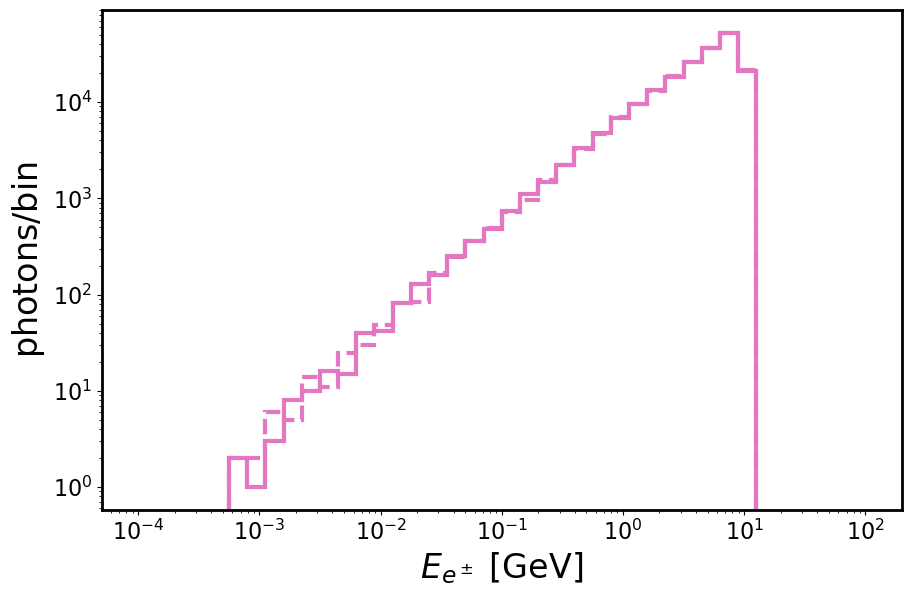

In [52]:
b0 = np.logspace(-4, 2, 41)

dens=False 

plt.hist(EsG, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-')
plt.hist(EsGP, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

#plt.gca().legend(loc=2, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(8.0, 5.0)


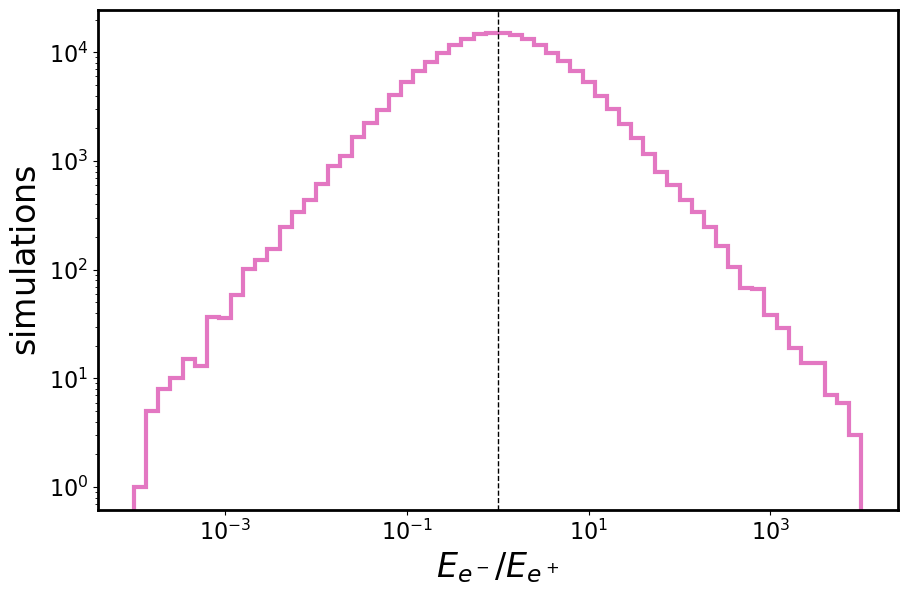

In [54]:
b0 = np.logspace(-4, 4, 61)

plt.hist(EsG/EsGP, bins=b0, histtype='step', lw=3, color='C6', density=False, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")

#plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^-}/E_{e^+}$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{simulations}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]
plt.gca().axvline(1.0, color='k', lw=1, ls='--')

set_size(8.0, 5.0)


Check the asymmetry of the distribution

In [55]:
(len(np.where(EsG > E0/2)[0]) - len(np.where(EsG < E0/2)[0]))/len(EsG)

-0.00027